# Feature Analysis

In [86]:
import pandas as pd
import math
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

In [87]:
smear_e = 1
pt_min = 0.3
ep_min = 0.1

In [88]:
filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
filenames2 = ['dalitz_100M_v0.zip','dalitz_100M_v1.zip','dalitz_100M_v2.zip','dalitz_100M_v3.zip','dalitz_100M_v4.zip']
filenames1 = ['pionminus_05_100M_v0.zip','pionminus_05_100M_v1.zip','pionminus_05_100M_v2.zip','pionminus_05_100M_v3.zip',\
              'pion_plus_05_100M_v0.zip','pion_plus_05_100M_v1.zip','pion_plus_05_100M_v2.zip','pion_plus_05_100M_v3.zip',\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
filenames1 = [\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
n_e_tot = 50e6
n_h_tot = 200e6

In [89]:
#filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
#filenames2 = ['dalitz_100M_v0.zip']
#filenames1 = ['pionminus_100M_v0.zip','pionplus_100M_v0.zip']
#n_e_tot = 10e6
#n_h_tot = 50e6

In [90]:
def read_csvs_from_zip(zpath):
    """Return a single DataFrame by concatenating all CSVs inside zpath."""
    dfs = []
    with zipfile.ZipFile(zpath) as z:
        # pick only CSV files (ignore folders/others)
        csv_names = [n for n in z.namelist() if n.lower().endswith(".csv") and not n.endswith("/")]
        if not csv_names:
            print(f"[warn] no CSVs found in {zpath}")
        for name in csv_names:
            with z.open(name) as f:
                dfs.append(pd.read_csv(f))
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def ensure_zip_path(filepath, base):
    """Build a .zip path even if base already has extension."""
    if base.lower().endswith(".zip"):
        return os.path.join(filepath, base)
    else:
        return os.path.join(filepath, f"{base}.zip")

# --- build data1 (phi0 = 0) ---
zpath = ensure_zip_path(filepath, filenames1[0])
data1 = read_csvs_from_zip(zpath)
data1["phi0"] = 0

for ifile in range(1, len(filenames1)):
    zpath = ensure_zip_path(filepath, filenames1[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 0
        print(idata.shape[0])
        data1 = pd.concat([data1, idata], ignore_index=True, sort=False)

# --- build data2 (phi0 = 1) ---
zpath = ensure_zip_path(filepath, filenames2[0])
data2 = read_csvs_from_zip(zpath)
data2["phi0"] = 1

for ifile in range(1, len(filenames2)):
    zpath = ensure_zip_path(filepath, filenames2[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 1
        data2 = pd.concat([data2, idata], ignore_index=True, sort=False)



ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
data1['weight'] = data1['weight'] / n_h_tot * 1e8
data2['weight'] = data2['weight'] / n_e_tot * 1e8

In [ ]:
# --- merge, filter, shuffle ---
data = pd.concat([data1, data2], ignore_index=True, sort=False)
data = data[(data["pt"] > pt_min) & (data["pt"] < 25) & (data["n0"] > -1)]

In [ ]:
# shuffle for ML
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data.head()

,centrality,pt,p,ecore,n0,disp,chi2,npe0,sector,prob,emcdphi,emcdz,Q,pt_gen,weight,phi0
0,74,7.674095,8.012115,0.219155,1,5.433383,37.105972,1,3,0.207523,-0.005324,-2.560516,-1,7.548081,0.000211,0
1,77,8.976776,9.019325,0.614429,4,3.825943,10.486934,10,2,0.367726,-0.007708,-1.115707,-1,8.541917,0.000087,0
2,21,1.214381,1.241780,1.143253,3,3.152165,140.720673,9,6,0.285674,-0.003796,1.111649,-1,7.334146,0.000065,1
3,57,2.479403,2.489333,2.516574,4,2.665793,33.408127,7,4,0.780674,-0.000089,-0.404160,-1,6.756751,0.000055,1
4,16,7.279288,7.304140,0.463123,2,0.500571,43.850773,2,7,0.504535,-0.000963,0.221390,-1,6.841547,0.003724,0


In [ ]:
data['e/p']=data['ecore']/data['p']
data['chi2/npe0']=data['chi2']/data['npe0']

In [ ]:
data = data[(data["e/p"] > ep_min)]

In [ ]:
import numpy as np

if smear_e:
    mom_scale  = 0.981  # B-field scale
    scale   = np.array([0.988, 0.990, 0.985, 0.981, 0.980, 0.985, 1.025, 1.023])
    smear_c1 = np.array([0.055, 0.066, 0.055, 0.059, 0.057, 0.056, 0.072, 0.072])
    smear_c2 = np.array([0.011, 0.017, 0.011, 0.013, 0.012, 0.012, 0.063, 0.062])

    n = len(data)
    rand = np.random.normal(size=n)

    # Randomly pick ONE index for the whole sample (as in your code).
    # If you meant one per row, see the note below.
    sector = data['sector'].to_numpy()
    pt     = data['pt'].to_numpy()
    ecore = data['ecore'].to_numpy()

    # Avoid divide-by-zero in the smearing term
    eps = 1e-12
    smear_sigma = np.sqrt(smear_c1[sector]**2 + (smear_c2[sector] / np.sqrt(np.maximum(ecore, eps)))**2)

    # Apply momentum scale and e/p smearing (in-place on DataFrame)
    data['pt']  = mom_scale * data['pt']
    data['e/p'] = data['e/p'] / mom_scale * (1.0 + rand * smear_sigma)


In [ ]:
if True:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['emcdphi'] = (data['emcdphi'].abs() < 0.02).astype(np.int8)
    data['emcdz'] = ( (data['emcdz'] - 1).abs() < 8 ).astype(np.int8)
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['chi2/npe0'] = (data['chi2/npe0'].abs() < 10).astype(np.int8)

if False:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['n0*pt'] = data['n0']+4*data['pt']
    data['e/p*pt'] = 1./((data['e/p']-0.9)*(data['e/p']-0.9)+0.25)/(1.25-data['prob'])+4*data['pt']
if False:
    data['disp2'] = data.apply(lambda row: row['n0']-row['disp']**2, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    #data['e/p*prob'] = data.apply(lambda row:  1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob']), axis=1)
    #data['n0*prob'] = data.apply(lambda row: (row['n0']-2)/(1.00001-row['prob']), axis=1)
    data['centr+pt'] = data.apply(lambda row: row['centrality']/20.+row['pt']*2, axis=1)
    data['e/p*pt'] = data.apply(lambda row: row['n0']+4*row['pt'], axis=1)
    data['n0*pt'] = data.apply(lambda row: 1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob'])+4*row['pt'], axis=1)

In [ ]:
# удалим лишние колонки
#data = data.drop(columns = ['zdc','emcdphi','emcdz'])
data = data.drop(columns = ['p','pt_gen','chi2'])

In [ ]:
data.head()

,centrality,pt,ecore,n0,disp,npe0,sector,prob,emcdphi,emcdz,Q,weight,phi0,e/p,chi2/npe0,disp2,centr+pt
2,21,1.191308,1.143253,3,3.152165,9,6,0.285674,1,1,-1,0.000065,1,0.887296,0,1.757982,2.469215
3,57,2.432294,2.516574,4,2.665793,7,4,0.780674,1,1,-1,0.000055,1,1.208691,1,3.111694,8.766056
5,26,1.514162,1.615266,6,1.459245,21,5,0.814840,1,1,-1,0.000240,1,1.060627,1,5.733825,3.592687
6,86,7.024365,1.192449,4,1.514528,16,2,0.000007,1,1,-1,0.000022,0,0.166645,1,3.713276,53.641709
7,28,0.646187,0.420411,6,1.518196,11,2,0.482765,1,1,-1,0.000186,1,0.645633,1,5.711885,1.817557


In [ ]:
print(data.size, data.shape)

440966043 (25939179, 17)


In [ ]:
def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    
    features = ['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'Q', 'prob', 'phi0']
    
    # Define (min, max, bins) for each feature
    ranges = [
        (0, 100, 50),   # centrality
        (0, 10, 50),    # pt
        (0, 2, 40),     # e/p
        (0, 12, 24),    # n0
        (0, 10, 40),    # disp
        (0, 1, 40),     # chi2/npe0
        (-1, 1, 40),    # Q
        (0, 1, 40),     # prob
        (0, 1, 40),     # phi0
    ]
    
    for i, feature in enumerate(features):
        x, y = divmod(i, 3)
        ax_here = ax[x][y]
        xmin, xmax, nbins = ranges[i]
        
        bins = np.linspace(xmin, xmax, nbins+1)  # edges
        ax_here.hist(data[feature], bins=bins, color="skyblue", log=True)
        
        ax_here.set_xlim(xmin, xmax)
        ax_here.set_title(feature)
        ax_here.set_ylabel('')
    
    plt.tight_layout()
    return fig, ax


(<Figure size 1500x600 with 9 Axes>,
 array([[<Axes: title={'center': 'centrality'}>,
         <Axes: title={'center': 'pt'}>, <Axes: title={'center': 'e/p'}>],
        [<Axes: title={'center': 'n0'}>, <Axes: title={'center': 'disp'}>,
         <Axes: title={'center': 'chi2/npe0'}>],
        [<Axes: title={'center': 'Q'}>, <Axes: title={'center': 'prob'}>,
         <Axes: title={'center': 'phi0'}>]], dtype=object))

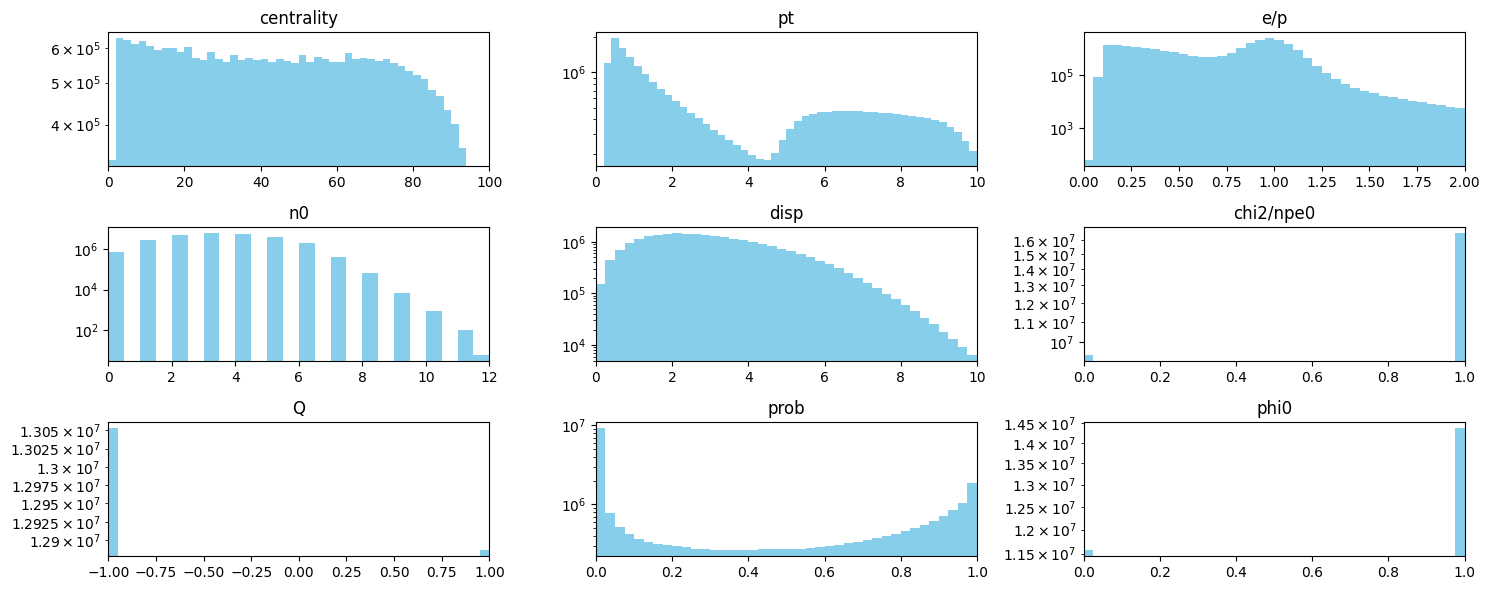

In [ ]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [ ]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)
    kek_data = data[cut_off_test:]
    y = data['phi0']
    w = data['weight']
    data = data.drop(columns = ['weight'])
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    w_train, w_test = w.iloc[:cut_off_test], w.iloc[cut_off_test:]

    return data_train, data_test, y_train, y_test, w_train, w_test, cut_off_val, kek_data

In [ ]:
X_train_all, X_test, y_train_all, y_test, w_train_all, w_test, cut_off_val, kek_data = feature_engineering(data)

8646393 17292787


In [ ]:
X_test

,centrality,pt,ecore,n0,disp,npe0,sector,prob,emcdphi,emcdz,Q,e/p,chi2/npe0,disp2,centr+pt
23710790,22,5.571352,0.985441,2,3.180259,5,7,8.500017e-01,1,1,-1,0.186599,1,0.735744,32.139958
23710791,63,5.257376,2.746954,1,3.866750,1,7,3.275627e-27,1,1,-1,0.604620,0,-0.868969,30.789999
23710793,26,0.750437,0.686646,6,3.259377,20,3,4.631526e-02,1,1,-1,0.945096,1,4.672058,1.863156
23710797,43,5.592364,1.416905,2,4.659636,2,1,5.803393e-05,1,1,-1,0.223916,1,-0.714025,33.424531
23710798,63,5.598701,2.111405,1,5.278773,1,0,3.884520e-02,1,1,-1,0.371702,0,-2.483180,34.495448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35568049,36,0.857648,0.915398,4,1.429093,7,4,9.907115e-01,1,1,-1,0.995541,0,3.744712,2.535560
35568050,35,3.449141,0.455819,3,4.594618,5,5,5.167016e-01,1,1,-1,0.125230,0,0.361186,13.646576
35568051,8,2.013755,1.955146,3,2.566235,9,4,3.346189e-01,1,1,-1,0.959686,1,2.176805,4.455210
35568052,43,8.979583,3.142478,2,2.859174,2,3,2.545240e-05,1,1,1,0.351774,1,0.978141,82.782913


In [ ]:
X_train, X_val = X_train_all, X_train_all[cut_off_val:]
y_train, y_val = y_train_all, y_train_all[cut_off_val:]
w_train, w_val = w_train_all, w_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb

# ---- 1) Baseline XGBoost model (mapped from your GB settings) ----
# - loss="log_loss"        -> objective="binary:logistic" (or multi:softprob if multi-class)
# - learning_rate=0.2      -> learning_rate
# - min_samples_split=0.01 -> (rough analog) min_child_weight; not directly comparable
# - max_depth=10           -> max_depth
# - max_features="sqrt"    -> colsample_bytree≈sqrt -> use 0.707
# - criterion ignored (not in XGB)
# - n_estimators=10        -> n_estimators

n_classes = len(np.unique(y_train))
objective = "binary:logistic" if n_classes == 2 else "multi:softprob"

xgb_clf = xgb.XGBClassifier(
    objective=objective,
    num_class=None if n_classes == 2 else n_classes,
    n_estimators=2,
    learning_rate=0.2,
    max_depth=10,
    min_child_weight=1,     # loose analog to min_samples_split
    colsample_bytree=0.707, # ~sqrt features
    subsample=1.0,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",  # safe default for classification
    random_state=0,
    n_jobs=3
)

xgb_clf.fit(X_train, y_train, sample_weight=w_train)
pred = xgb_clf.predict(X_test)

print(metrics.classification_report(y_test, pred))
print("confusion matrix")
print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80   3857714
           1       0.99      0.60      0.75   4788678

    accuracy                           0.78   8646392
   macro avg       0.83      0.80      0.77   8646392
weighted avg       0.85      0.78      0.77   8646392

confusion matrix
[[3821510   36204]
 [1894179 2894499]]


In [ ]:
if False:
    # ---- 2) Grid search with cross-validation ----
    # Keep your single-value choices; feel free to widen later.
    param_grid = {
        "learning_rate": [0.2],
        "max_depth": [10,20],
        "n_estimators": [20,30],
        # sensible XGB counterparts to explore (optional to widen later)
        "min_child_weight": [1],
        "colsample_bytree": [0.707],
        "subsample": [1.0],
        "reg_lambda": [1.0],
    }

    est = xgb.XGBClassifier(
        objective=objective,
        num_class=None if n_classes == 2 else n_classes,
        tree_method="hist",
        eval_metric="logloss",
        random_state=0,
        n_jobs=3
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    clf = GridSearchCV(
        estimator=est,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=3,
        verbose=0,
    )

    # IMPORTANT: pass sample_weight through GridSearchCV.fit so it reaches XGB.fit
    clf.fit(X_train, y_train, **{"sample_weight": w_train})

    print("точность: ", clf.score(X_test, y_test))
    print(clf.best_params_)
    print(clf.best_score_)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb

# --- custom metric (top level) ---
def tpr2_over_fpr_thresh(y_true, y_proba, fpr_max=0.05, tpr_min=0.33):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    mask = np.ones_like(fpr, dtype=bool)
    if fpr_max is not None:
        mask &= (fpr <= fpr_max)
    if tpr_min is not None:
        mask &= (tpr >= tpr_min)

    if not np.any(mask):
        return 0.0

    fpr, tpr = fpr[mask], tpr[mask]
    eps = 1e-12
    j_values = (tpr**1) / np.maximum(fpr, eps)
    idx = np.argmax(j_values)
    return float(j_values[idx]), float(tpr[idx]), float(fpr[idx])

def scorer_only(y_true, y_proba, fpr_max=0.05, tpr_min=0.5):
    score, _, _ = tpr2_over_fpr_thresh(y_true, y_proba, fpr_max, tpr_min)
    return score

custom_scorer = make_scorer(
    scorer_only, needs_proba=True, greater_is_better=True, fpr_max=0.05, tpr_min=0.49
)


base = xgb.XGBClassifier(
    objective="binary:logitraw",
    eval_metric="logloss",
    tree_method="hist",
    random_state=0,
    n_jobs=4,
)

param_grid = {
    # capacity & learning dynamics
    "n_estimators": [40, 60],     # more trees w/ smaller LR tends to help ROC extremes
    "learning_rate": [0.05, 0.01],
    # tree shape / smoothness
    "max_depth": [8, 12],
    "min_child_weight": [1],
    "gamma": [0.0, 1.0],            # split cost; higher → fewer splits (can reduce FPR)
    # randomness / feature sampling
    "subsample": [1.0],
    "colsample_bytree": [0.4],
    # imbalance handling (set if classes imbalanced)
    # "scale_pos_weight": [1.0, float((y_train==0).sum()/(y_train==1).sum())],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring=custom_scorer,  # <-- only here
    refit=True,             # <-- NOT the scorer; True is correct
    cv=cv,
    n_jobs=4,
    verbose=0,
)

# Fit (weights used in fitting; scoring is unweighted unless you do manual CV)
grid.fit(X_train, y_train, sample_weight=w_train)

best_xgb = grid.best_estimator_

# recompute full info
y_scores = best_xgb.predict_proba(X_test)[:, 1]
score, best_tpr, best_fpr = tpr2_over_fpr_thresh(y_test, y_scores, fpr_max=0.05, tpr_min=0.33)

print("Best params:", grid.best_params_)
print(f"Best custom score (max TPR^2/FPR): {score:.4f}")
print(f"Corresponding TPR: {best_tpr:.4f}, FPR: {best_fpr:.4e}")


/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best params: {'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 60, 'subsample': 1.0}
Best custom score (max TPR^2/FPR): 168.6010
Corresponding TPR: 0.3300, FPR: 6.4598e-04


# Cross Validation

In [91]:
clf = grid
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      1.00      0.78   3857714
           1       0.99      0.56      0.72   4788678

    accuracy                           0.76   8646392
   macro avg       0.82      0.78      0.75   8646392
weighted avg       0.84      0.76      0.75   8646392



   feature  importance
 chi2/npe0 2202.425537
     emcdz 2020.645020
      npe0 1791.332153
     disp2 1787.207031
       e/p 1438.721191
        n0 1309.454956
   emcdphi 1136.582520
     ecore  820.741760
      disp  771.698975
        pt  622.027466
centrality  562.210083
      prob  514.087463
  centr+pt  339.871155
    sector  337.213989
         Q  224.065247


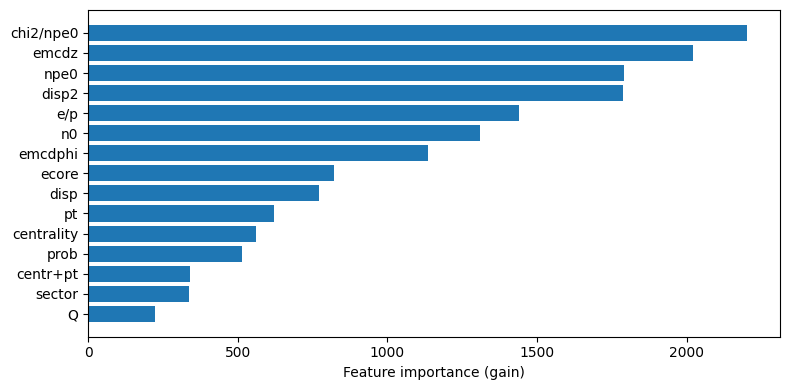

In [92]:
# ---- Feature importance for XGBoost ----
# Use the *best* model from GridSearchCV
xgb_best = clf.best_estimator_
booster  = xgb_best.get_booster()

# pick an importance type you like
imp_dict = booster.get_score(importance_type="gain")  # or "weight", "cover", "total_gain", "total_cover"

# Booster’s internal feature names (may be actual column names or f0,f1,...)
booster_names = booster.feature_names
if booster_names is None:
    # Fallback (older versions); assume f0..f{n-1}
    booster_names = [f"f{i}" for i in range(len(X_train.columns))]

# Build a mapping for both possibilities: by real name, or by f{i}
name_to_findex = {name: i for i, name in enumerate(X_train.columns)}

rows = []
for name in X_train.columns:
    fi = imp_dict.get(name, None)
    if fi is None:
        i = name_to_findex[name]
        fi = imp_dict.get(f"f{i}", 0.0)
    rows.append((name, float(fi)))

fi_df = pd.DataFrame(rows, columns=["feature", "importance"]).sort_values("importance", ascending=False)
print(fi_df.to_string(index=False))

# Optional plot
plt.figure(figsize=(8, 4))
plt.barh(fi_df.feature[::-1], fi_df.importance[::-1])
plt.xlabel("Feature importance (gain)")
plt.tight_layout()
plt.show()

if False:  # more precise but slow
    from sklearn.inspection import permutation_importance
    pi = permutation_importance(
        xgb_best, X_test, y_test,
        n_repeats=5, random_state=42, n_jobs=3,
        sample_weight=w_test  # keep if your sklearn supports it
    )
    pi_df = pd.DataFrame({
        "feature": feat_names,
        "perm_importance_mean": pi.importances_mean,
        "perm_importance_std": pi.importances_std
    }).sort_values("perm_importance_mean", ascending=False)
    print(pi_df.to_string(index=False))


In [93]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.27985543736925056
roc auc: 0.9456721702201345
f1 score: 0.3530403209734636


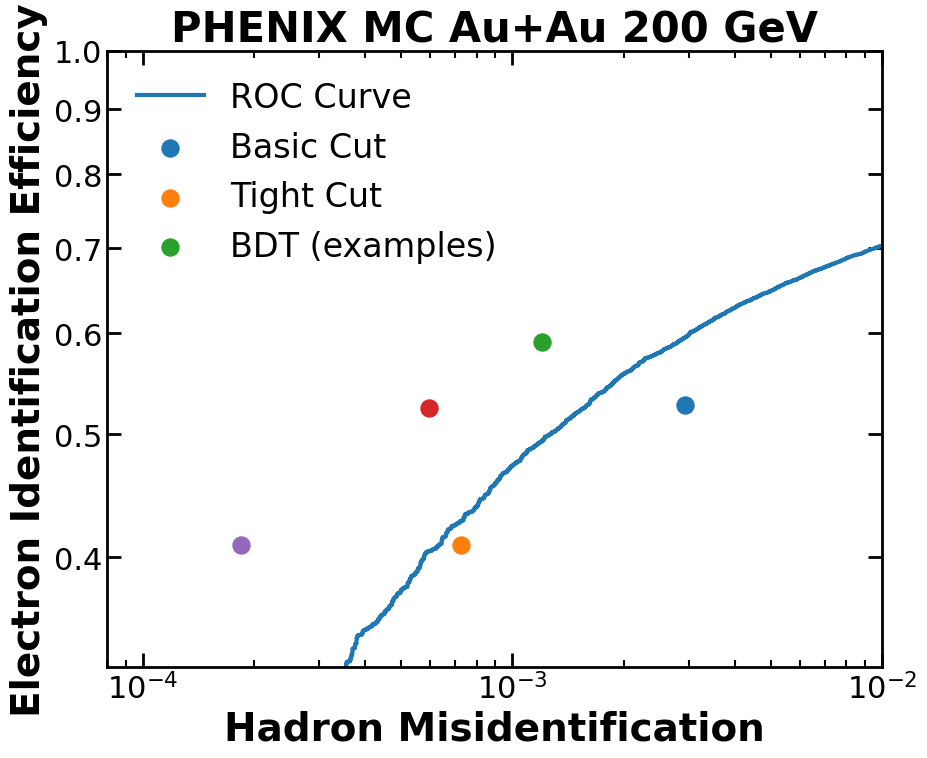

In [94]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# --- loss
print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

# --- AUC (binary vs multiclass)
if y_pred_probs.shape[1] == 2:
    # binary
    y_scores = y_pred_probs[:, 1]
    auc = roc_auc_score(y_test, y_scores, sample_weight=w_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores, pos_label=1, sample_weight=w_test)
else:
    # multiclass (OvR)
    auc = roc_auc_score(y_test, y_pred_probs, average='ovr', multi_class='ovr', sample_weight=w_test)
    # choose a class to display ROC for (e.g., positive class = 1)
    pos_class = 1
    y_bin = (y_test == pos_class).astype(int)
    y_scores = y_pred_probs[:, pos_class]
    fpr, tpr, thresholds = metrics.roc_curve(y_bin, y_scores, pos_label=1, sample_weight=w_test)

print('roc auc:', auc)

# --- optimal threshold on the *unscaled* ROC (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_scores > optimal_threshold
print('f1 score:', f1_score(y_test if y_pred_probs.shape[1]==2 else y_bin, y_pred_opt, sample_weight=w_test))

# --- Plot ROC with your rescaling
plt.figure(figsize=(10, 8))

rej = 25/2.0  # hadron rejection scaling
eff = 0.8     # efficiency scaling

# Avoid zeros before log-scale
eps = 1e-12
fpr_scaled = np.clip(fpr / rej, eps, None)
tpr_scaled = np.clip(tpr * eff, eps, None)

plt.plot(fpr_scaled, tpr_scaled, label='ROC Curve', linewidth=3)

# Helper to safely scatter on log axes
def _safe_point(x, y):
    return max(x, eps), max(y, eps)

# Reference points (scaled like your axes)
bx, by = _safe_point(1/1.5/rej*0.055, eff*0.659)
tx, ty = _safe_point(1/1.5/rej*0.0136, eff*0.511)
lx, ly = _safe_point(1/rej*0.0150,    eff*0.738)
bx2,by2= _safe_point(1/rej*0.00745,   eff*0.655)
tx2,ty2= _safe_point(1/rej*0.0023,    eff*0.511)

plt.scatter(bx,  by,  label='Basic Cut',  s=150, zorder=5)
plt.scatter(tx,  ty,  label='Tight Cut',  s=150, zorder=5)
plt.scatter(lx,  ly,  label='BDT (examples)', s=150, zorder=5)
plt.scatter(bx2, by2, label='_nolegend_', s=150, zorder=5)  # no duplicate legend
plt.scatter(tx2, ty2, label='_nolegend_', s=150, zorder=5)

# Log axes
plt.xscale('log')
plt.yscale('log')

# Limits (respect scaling)
plt.xlim(1e-3/rej, 1/100)
plt.ylim(0.41*eff, 1.0*eff)

# Ticks / style
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)

plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficiency", fontsize=28, fontweight='bold')
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

plt.legend(fontsize=24, loc='upper left', frameon=False)

for side in ('top','right','left','bottom'):
    ax.spines[side].set_linewidth(2)

plt.savefig("output/roc_auc_curve_new.pdf", bbox_inches='tight', transparent=True)
plt.show()

log loss: 0.27985543736925056
roc auc: 0.9456721702201345
f1 score: 0.8626302324355053


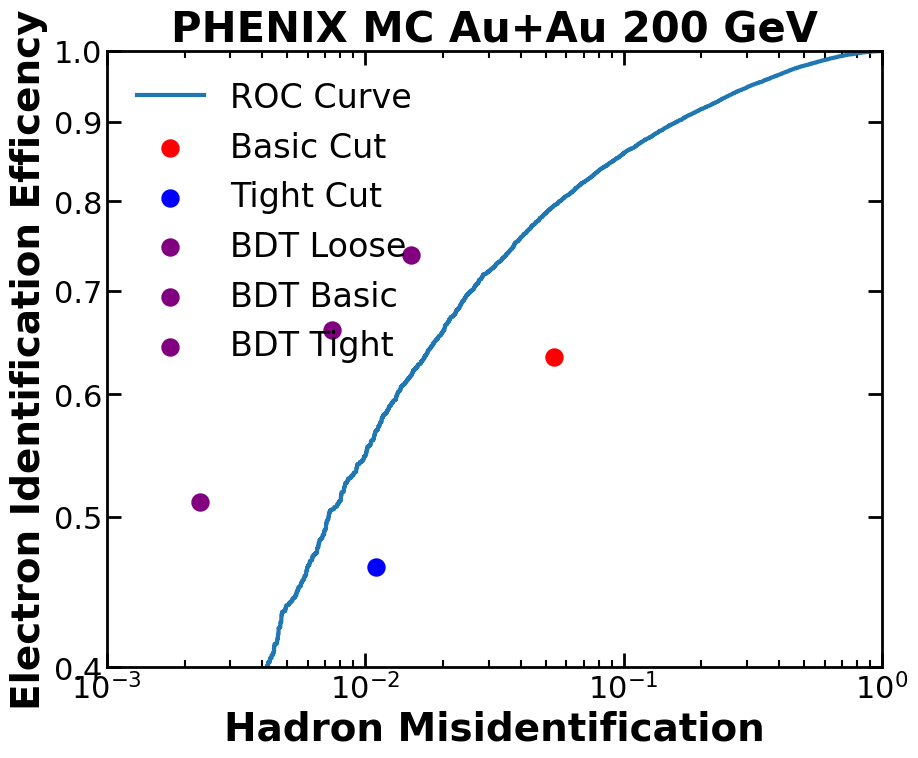

In [95]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.figure(figsize=(10, 8))

rej = 1
eff = 1

fpr = fpr / rej
tpr = tpr *eff
# Plot curves with increased line width
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
#plt.plot(fpr, fpr, label='Random Guess', linestyle='--', linewidth=3)

# Add larger points to the plot  # Increased size with `s`
plt.scatter(1/rej*0.054, eff*0.634, color='red', label='Basic Cut', s=150, zorder=5)
plt.scatter(1/rej*0.011, eff*0.464, color='blue', label='Tight Cut', s=150, zorder=5)
plt.scatter(1/rej*0.0150, eff*0.738, color='purple', label='BDT Loose', s=150, zorder=5)
plt.scatter(1/rej*0.00745, eff*0.66, color='purple', label='BDT Basic', s=150, zorder=5)
plt.scatter(1/rej*0.0023, eff*0.511, color='purple', label='BDT Tight', s=150, zorder=5)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the same range for both axes
plt.xlim(1e-3/rej, 1/rej/rej**0.5)
plt.ylim(0.41*eff, 1*eff)

# Customize y-axis ticks explicitly
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

# Disable scientific notation on the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

# Enable minor ticks and customize tick size
plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)  # Major ticks
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)  # Minor ticks

# Add labels with larger font size
plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficency", fontsize=28, fontweight='bold')
plt.xticks(fontsize=22)
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

# Customize legend with larger font size and no box
plt.legend(fontsize=24, loc='upper left', frameon=False)

# Thicker plot frame
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the plot with a transparent background
plt.savefig("output/roc_auc_curve_new_centr.pdf", bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [96]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.6873394272034913


In [97]:
i = 2200000
print(round(fpr[i],3),round(tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
print(fpr[i]/tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.005 0.4412
0.76530945 0.005188804275251431 0.4411528089606678
0.01176192051791753


In [98]:
print(sum(predicted),len(predicted))

2701261 8646392


In [99]:
#kek_data = data
#kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(X_test)
print(proba_loc[0][1])

-3.041236


In [100]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 40, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 40, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 40, 0, 10, 10, 0, 100)
e_pt_hist_TC = root.TH2D("e_pt_hist_TC", "e_pt_hist_TC", 40, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 40, 0, 10, 10, 0, 100)
h_pt_hist_TC = root.TH2D("h_pt_hist_TC", "h_pt_hist_TC", 40, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 40, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 40, 0, 10, 10, 0, 100)

In [101]:
mycute,mycuth,tcute,tcuth, AIcute, AIcuth = 0, 0, 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = kek_data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>10000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2/npe0'], row['n0'], row['prob'], row['phi0']
    w = row['weight']/1e8
    if pt<0.4 or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality,w)
    else:    h_pt_hist_NC.Fill(pt,centrality,w)
    if ep>0.8 and n0>=2 and disp <5 and chi2<1: 
        if phi0: 
            mycute+=w
            e_pt_hist_SC.Fill(pt,centrality,w)
        else: 
            mycuth+=w
            h_pt_hist_SC.Fill(pt,centrality,w)

    if ep>0.8 and n0>=2 + disp**2/8 and disp <4 and prob>0.01 and chi2<1: 
        if phi0: 
            tcute+=w
            e_pt_hist_TC.Fill(pt,centrality,w)
        else: 
            tcuth+=w
            h_pt_hist_TC.Fill(pt,centrality,w)
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: 
            AIcute+=w
            e_pt_hist_AI.Fill(pt,centrality,w)
        else: 
            AIcuth+=w
            h_pt_hist_AI.Fill(pt,centrality,w)
    if phi0: norm_e+=w
    else: norm_h+=w
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

KeyboardInterrupt: 

In [ ]:
print(norm_e, norm_h, round(mycute/norm_e,3),round(mycuth/norm_h,3),round(tcute/norm_e,3),round(tcuth/norm_h,4), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i],3),round(tpr[i],3))

0.008136824172284235 0.3261708336650482 0.153 0.028 0.066 0.0034 0.399 0.003 0.007 0.005 0.441


In [ ]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h), counter)

26.662 2.615 0.098 4344 8646391


In [ ]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [ ]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2e-11)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw("H")

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2e-11)
    projh.Draw("Hist")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.00037811945432135127 2.359127600148528e-06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [ ]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,3)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    #legends[-1].SetNColumns(2)
    legends[-1].AddEntry(proj,"e tot","l")
    legends[-1].AddEntry(phoj_s,"e std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2),"e bdt","l")
    legends[-1].Draw("H")

    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(6)
    h_pt_hist_SC.SetLineColor(3)
    h_pt_hist_AI.SetLineColor(7)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=6,  Lwidth=3,  Lcolor=6,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.Draw("Hist same")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")
    legends[-1].AddEntry(projh,"h tot","l")
    legends[-1].AddEntry(phoj_sd,"h std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2),"h bdt","l")
    legends[-1].Draw()

    proj.SetMaximum(max(proj.GetMaximum(),projh.GetMaximum())*2)
    proj.SetMinimum(2e-12)


c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.00037811945432135127 2.359127600148528e-06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [ ]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [ ]:
import pickle
with open('output/bdtasdfs.pkl','wb') as f:
    pickle.dump(clf,f)

#print(clf.predict(X_test[0:10]))

In [ ]:
import pickle
# load
with open('output/bdtasdfs.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(X_test[0:10]))

[0 0 0 0 0 1 0 0 0 1]


In [ ]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

TypeError: 'XGBClassifier' object is not subscriptable

In [ ]:
clf2.predict(X_test[0:100])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [ ]:
clf2.predict_proba(X_test[0:100])

array([[0.92127593, 0.07872407],
       [0.93213004, 0.06786996],
       [0.51667297, 0.48332703],
       [0.93327436, 0.06672564],
       [0.93215573, 0.06784427],
       [0.13760351, 0.86239649],
       [0.88801316, 0.11198684],
       [0.90881212, 0.09118788],
       [0.92787823, 0.07212177],
       [0.22324306, 0.77675694],
       [0.20747167, 0.79252833],
       [0.60595632, 0.39404368],
       [0.8331314 , 0.1668686 ],
       [0.81999474, 0.18000526],
       [0.14018992, 0.85981008],
       [0.63364847, 0.36635153],
       [0.09998437, 0.90001563],
       [0.88031885, 0.11968115],
       [0.89291385, 0.10708615],
       [0.61170931, 0.38829069],
       [0.93449814, 0.06550186],
       [0.11131388, 0.88868612],
       [0.10995877, 0.89004123],
       [0.33434165, 0.66565835],
       [0.80590279, 0.19409721],
       [0.78457563, 0.21542437],
       [0.86054769, 0.13945231],
       [0.32763053, 0.67236947],
       [0.93017762, 0.06982238],
       [0.93404503, 0.06595497],
       [0.

In [ ]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 10}


In [ ]:
clf2.best_estimator_.predict_proba(X_test[9:20])

array([[0.22324306, 0.77675694],
       [0.20747167, 0.79252833],
       [0.60595632, 0.39404368],
       [0.8331314 , 0.1668686 ],
       [0.81999474, 0.18000526],
       [0.14018992, 0.85981008],
       [0.63364847, 0.36635153],
       [0.09998437, 0.90001563],
       [0.88031885, 0.11968115],
       [0.89291385, 0.10708615],
       [0.61170931, 0.38829069]])

In [ ]:
y = clf2.best_estimator_[0, 0].predict(X_test[9:19].values.tolist())*0
#y = gb_clf.decision_function(X_test[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(X_test[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(X_test[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[ 1.24686635  1.34023348 -0.43034613 -1.60798466 -1.51631187  1.81371344
 -0.547901    2.1973983  -1.99545308 -2.12085643]
[-3.2119646  -2.46437374 -2.62281512 -2.62281512 -3.54363283 -3.34831901
 -2.46437374 -2.32801932 -3.50294386 -2.62281512 -2.32801932]
[0.77675694 0.79252833 0.39404368 0.1668686  0.18000526 0.85981008
 0.36635153 0.90001563 0.11968115 0.10708615]


In [ ]:
best_gbc = clf2.best_estimator_

In [ ]:
n_estim = best_gbc.n_estimators

In [ ]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(X_test[9:19]))
arr = clf2.decision_function(X_test[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(X_test[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 1.24686635  1.34023348 -0.43034613 -1.60798466 -1.51631187  1.81371344
 -0.547901    2.1973983  -1.99545308 -2.12085643]
[0.77675694 0.79252833 0.39404368 0.1668686  0.18000526 0.85981008
 0.36635153 0.90001563 0.11968115 0.10708615]
0.2


In [ ]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(X_test[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(X_test[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [ ]:
print(log_odds_predictions)

[[-0.22578107118513677, 1.4002853434780411, -1.2013509197121797, -1.9023886843471065, -1.9893652680519693, 1.9308184779161301, 0.22394325215068564, 1.4002853434780411, -1.953300840273101, -1.9438027712652992], [-1.0794726771772256, 1.3815115955852502, -1.4815833831970162, -1.5088607992326273, 1.5394665061031836, -0.11076236671183932, -1.2236092347654313, 1.3815115955852502, -1.424610263661202, -1.2895854252770493], [1.4147403035640207, 1.4147403035640207, -1.4571817522379436, -1.4571817522379436, 0.4485777229861383, 0.4515851567450008, 0.018151782918847673, 1.5668224080244548, -1.2276230270907587, -1.447455788072534], [0.5314409459120867, 0.9893274980661386, -0.7013621284667948, -1.3554607552574567, -1.3587019596487993, 0.9893274980661386, 0.19246770288330092, 0.9893274980661386, -1.1194707497568435, -1.3128936132546043], [1.1908997644026853, 1.0937488140063378, 1.0089544661295806, -1.1296260601327945, -1.2285722737628877, 1.5414026245458117, -0.14422224831323285, 1.0937488140063378, -

In [ ]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(X_test[9:19]))

0.2 1.2468663469455672
[ 1.24686635  1.34023348 -0.43034613 -1.60798466 -1.51631187  1.81371344
 -0.547901    2.1973983  -1.99545308 -2.12085643]


In [ ]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(X_test[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

10
1
[[-0.22578107118513677, -1.0794726771772256, 1.4147403035640207, 0.5314409459120867, 1.1908997644026853, 1.376573047056587, -0.011347429746431941, 1.2887921798064623, 0.849289260240743, 0.8991974118540442], [1.4002853434780411, 1.3815115955852502, 1.4147403035640207, 0.9893274980661386, 1.0937488140063378, -0.08055421722238347, 0.8213532797386718, -0.18452080936029713, -0.7050070279086446, 0.5702826067251399], [-1.2013509197121797, -1.4815833831970162, -1.4571817522379436, -0.7013621284667948, 1.0089544661295806, -0.8516900735140597, 1.0958797206586641, 1.1637868680229178, -0.9786108346414676, 1.2514274074654748], [-1.9023886843471065, -1.5088607992326273, -1.4571817522379436, -1.3554607552574567, -1.1296260601327945, -1.083443645455266, -0.5610644745424441, 1.1637868680229178, -1.0409932067744556, 0.835309206047928], [-1.9893652680519693, 1.5394665061031836, 0.4485777229861383, -1.3587019596487993, -1.2285722737628877, -1.1215658895575582, -1.1427024283604672, -1.1157742916834545

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
#print(f"double mytree{list(X_test.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[11] > 0.77484) if (x[3] > 3.5) if (x[14] > 1.5524) if (x[3] <= 4.5) if (x[12] > 0.5) if (x[0] > 35.5) if (x[7] > 0.02385) if (x[13] > -0.47611) if (x[8] > 0.5) if (x[1] > 0.37124)   return 1.4002853434780411;  // | based on 1,159,603 samples
        if  (x[11] <= 0.77484) if (x[0] > 49.5) if (x[13] <= 2.28558) if (x[13] > -0.11) if (x[1] > 0.36363) if (x[2] > 0.0714) if (x[1] > 0.45962) if (x[1] > 0.64265) if (x[11] <= 0.72377) if (x[11] > 0.1379)   return -1.9451861681271856;  // | based on 977,558 samples
        if  (x[11] > 0.77484) if (x[3] > 3.5) if (x[14] > 1.5524) if (x[3] > 4.5) if (x[4] <= 4.51382) if (x[7] > 0.06257) if (x[9] > 0.5) if (x[4] > 2.13302) if (x[5] > 7.5) if (x[7] > 0.09305)   return 1.503347722984372;  // | based on 948,452 samples
        if  (x[11] <= 0.77484) if (x[0] <= 49.5) if (x[5] <= 8.5) if (x[1] > 0.41087) if (x[4] > 3.46296) if (x[13] <= 0.23656) if (x[1] > 0.50931) if (x[5] <= 2.5) if (x[0] <= 36.5) if (x[

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[11] > 0.77484) and (x[3] > 3.5) and (x[14] > 1.5524) and (x[3] <= 4.5) and (x[12] > 0.5) and (x[0] > 35.5) and (x[7] > 0.02385) and (x[13] > -0.47611) and (x[8] > 0.5) and (x[1] > 0.37124) :  return 1.4002853434780411  # | based on 1,159,603 samples
        if (x[11] <= 0.77484) and (x[0] > 49.5) and (x[13] <= 2.28558) and (x[13] > -0.11) and (x[1] > 0.36363) and (x[2] > 0.0714) and (x[1] > 0.45962) and (x[1] > 0.64265) and (x[11] <= 0.72377) and (x[11] > 0.1379) :  return -1.9451861681271856  # | based on 977,558 samples
        if (x[11] > 0.77484) and (x[3] > 3.5) and (x[14] > 1.5524) and (x[3] > 4.5) and (x[4] <= 4.51382) and (x[7] > 0.06257) and (x[9] > 0.5) and (x[4] > 2.13302) and (x[5] > 7.5) and (x[7] > 0.09305) :  return 1.503347722984372  # | based on 948,452 samples
        if (x[11] <= 0.77484) and (x[0] <= 49.5) and (x[5] <= 8.5) and (x[1] > 0.41087) and (x[4] > 3.46296) and (x[13] <= 0.23656) and (x[1] > 0.5093

In [ ]:
def mytree(x,y):
    return 0

In [ ]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [ ]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(X_test[9:19].values.tolist())
print(y)

myf = [mytree(iestim, X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[ 0.89919741  0.57028261  1.25142741  0.83530921 -0.74744176  1.15318602
 -0.5812794   0.39583299 -0.91123584 -0.85512951]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.22324306 0.77675694]
 [0.20747167 0.79252833]
 [0.60595632 0.39404368]
 [0.8331314  0.1668686 ]
 [0.81999474 0.18000526]
 [0.14018992 0.85981008]
 [0.63364847 0.36635153]
 [0.09998437 0.90001563]
 [0.88031885 0.11968115]
 [0.89291385 0.10708615]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
input_x = [ X_test[9:19].values.tolist()[0][i] for i in range(len(X_test[9:19].values.tolist()[0])) ]
print(input_x)

[92.0, 0.39496938934922216, 0.3822766542434692, 3.0, 1.8919944763183596, 3.0, 6.0, 0.7755911946296692, 1.0, 1.0, 1.0, 1.0585837849053987, 1.0, 2.552544612697602, 4.756000818522897]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
y = [y[i][1] for i in range(len(y))]
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[0.7767569394964091, 0.7925283340806003, 0.3940436829292091, 0.16686860496077008, 0.18000525820517219, 0.8598100781572685, 0.3663515303772353, 0.900015633610553, 0.11968114710278116, 0.10708615250664025]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
column_headers = list(X_test.columns.values)
print(column_headers)
print(len(column_headers))

['centrality', 'pt', 'ecore', 'n0', 'disp', 'npe0', 'sector', 'prob', 'emcdphi', 'emcdz', 'Q', 'e/p', 'chi2/npe0', 'disp2', 'centr+pt']
15
